In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


### Create time-domain signal

In [21]:
# Parameters
fs = 120  # Sampling Frequency (Hz)
T = 1/fs  # seconds
N=500
t_samples = np.arange(0, N)  # sample indices
t_actual = t_samples / fs  # actual time in seconds

# Signal
comp1_freq_hz=48
comp2_freq_hz=10

noise_coeff=2

#Constuct signal
signal = (6 * np.sin(2*np.pi*comp1_freq_hz*t_actual) - 
          10 * np.cos(2*np.pi*comp2_freq_hz*t_actual) + 
          np.random.randn(len(t_actual)) * noise_coeff)


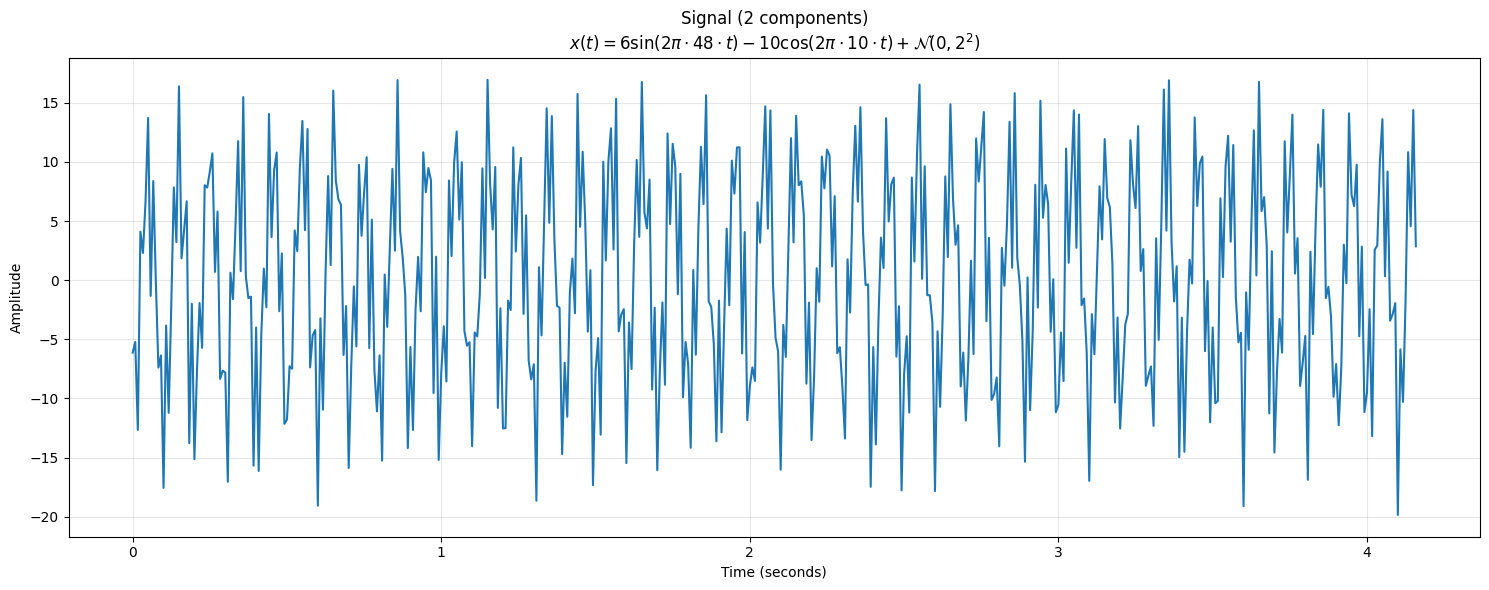

In [22]:
# Create formula string
formula = f"$x(t) = 6\sin(2\pi \cdot {comp1_freq_hz} \cdot t) - 10\cos(2\pi \cdot {comp2_freq_hz} \cdot t) + \mathcal{{N}}(0, {noise_coeff}^2)$"

# Plot
plt.figure(figsize=(15, 6))
plt.plot(t_actual, signal)
plt.title(f"Signal (2 components)\n{formula}", fontsize=12)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

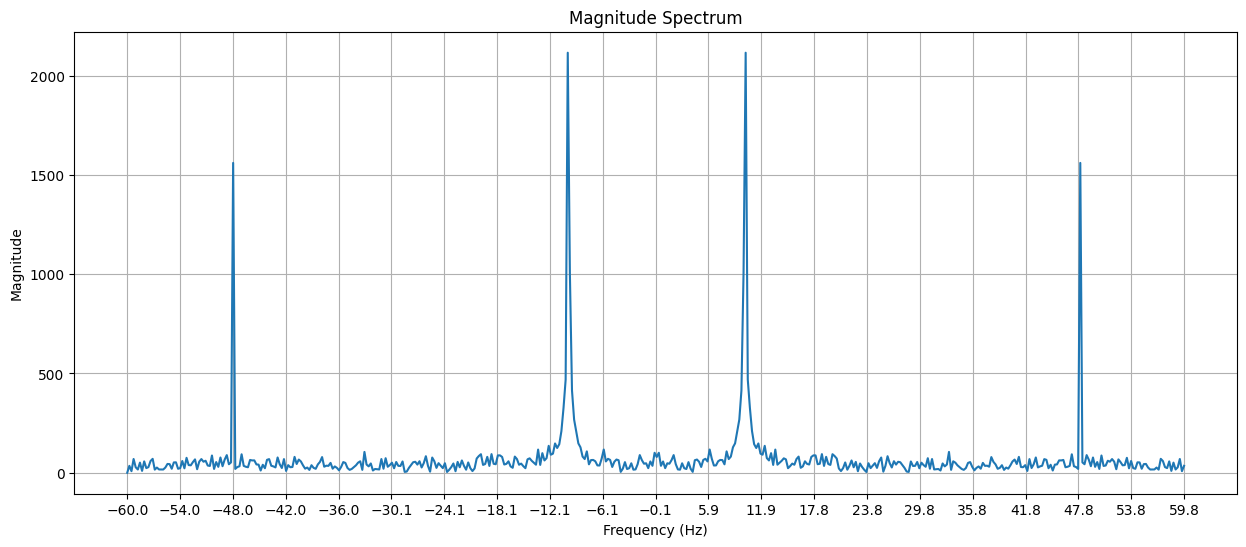

In [23]:
# Perform the FFT
X = np.fft.fft(signal)

# Get the frequency bins and shift them for a centered plot
frequencies = np.fft.fftfreq(N, d=t_samples[1]-t_samples[0])
# fftfreq with d=1 gives normalized frequencies (cycles/sample) ranging -0.5 to 0.5
# Multiply by fs to convert: normalized freq × fs = physical freq (Hz)
shifted_frequencies = np.fft.fftshift(frequencies) * fs #multible by sampling frequency to convert back to Physical Frequencies
shifted_X = np.fft.fftshift(X)

# Plot the magnitude spectrum
plt.figure(figsize=(15, 6))
plt.plot(shifted_frequencies, np.abs(shifted_X))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum')
plt.xticks(np.linspace(shifted_frequencies.min(), shifted_frequencies.max(), 21))
plt.grid(True)
plt.show()

### Reconstruct Signal



In [24]:
def extract_top_frequencies(signal, fs, k=5):
    """Extract top k dominant frequencies from signal"""
    N = len(signal)
    
    # FFT
    X = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, d=1/fs)
    
    # Positive frequencies only
    pos_mask = freqs > 0  # Exclude DC
    pos_freqs = freqs[pos_mask]
    pos_X = X[pos_mask]
    
    # Top k by magnitude
    mags = np.abs(pos_X)
    top_idx = np.argsort(mags)[-k:][::-1]
    
    return {
        'frequencies': pos_freqs[top_idx],
        'amplitudes': 2 * mags[top_idx] / N,  # Convert FFT mag to time-domain amp
        'phases': np.angle(pos_X[top_idx])
    }


def reconstruct_signal(freq_info, fs, N):
    """Reconstruct signal from frequency components"""
    t = np.arange(N) / fs
    signal = np.zeros(N)
    
    for freq, amp, phase in zip(freq_info['frequencies'], 
                                  freq_info['amplitudes'], 
                                  freq_info['phases']):
        signal += amp * np.cos(2*np.pi*freq*t + phase)
    
    return signal


def plot_comparison(t, original, reconstructed, freq_info, k):
    """Plot original vs reconstructed signal"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Original
    axes[0].plot(t, original, linewidth=0.8)
    axes[0].set_title('Original Signal')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Reconstructed
    axes[1].plot(t, reconstructed, linewidth=0.8, color='orange')
    axes[1].set_title(f'Reconstructed (Top {k} Frequencies)')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    
    # Overlay
    axes[2].plot(t, original, linewidth=0.8, alpha=0.6, label='Original')
    axes[2].plot(t, reconstructed, linewidth=0.8, alpha=0.6, label='Reconstructed')
    axes[2].set_title('Comparison')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Amplitude')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Add R² metric
    r_squared = np.corrcoef(original, reconstructed)[0, 1]**2
    axes[2].text(0.02, 0.98, f'R² = {r_squared:.4f}', 
                transform=axes[2].transAxes, fontsize=12, va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


Top 2 Frequencies:
--------------------------------------------------
1.  10.08 Hz  |  Amplitude:   8.46
2.  48.00 Hz  |  Amplitude:   6.24
--------------------------------------------------

Reconstruction Quality:
  R² (variance explained): 0.7430 (74.3%)
  RMSE: 4.3751


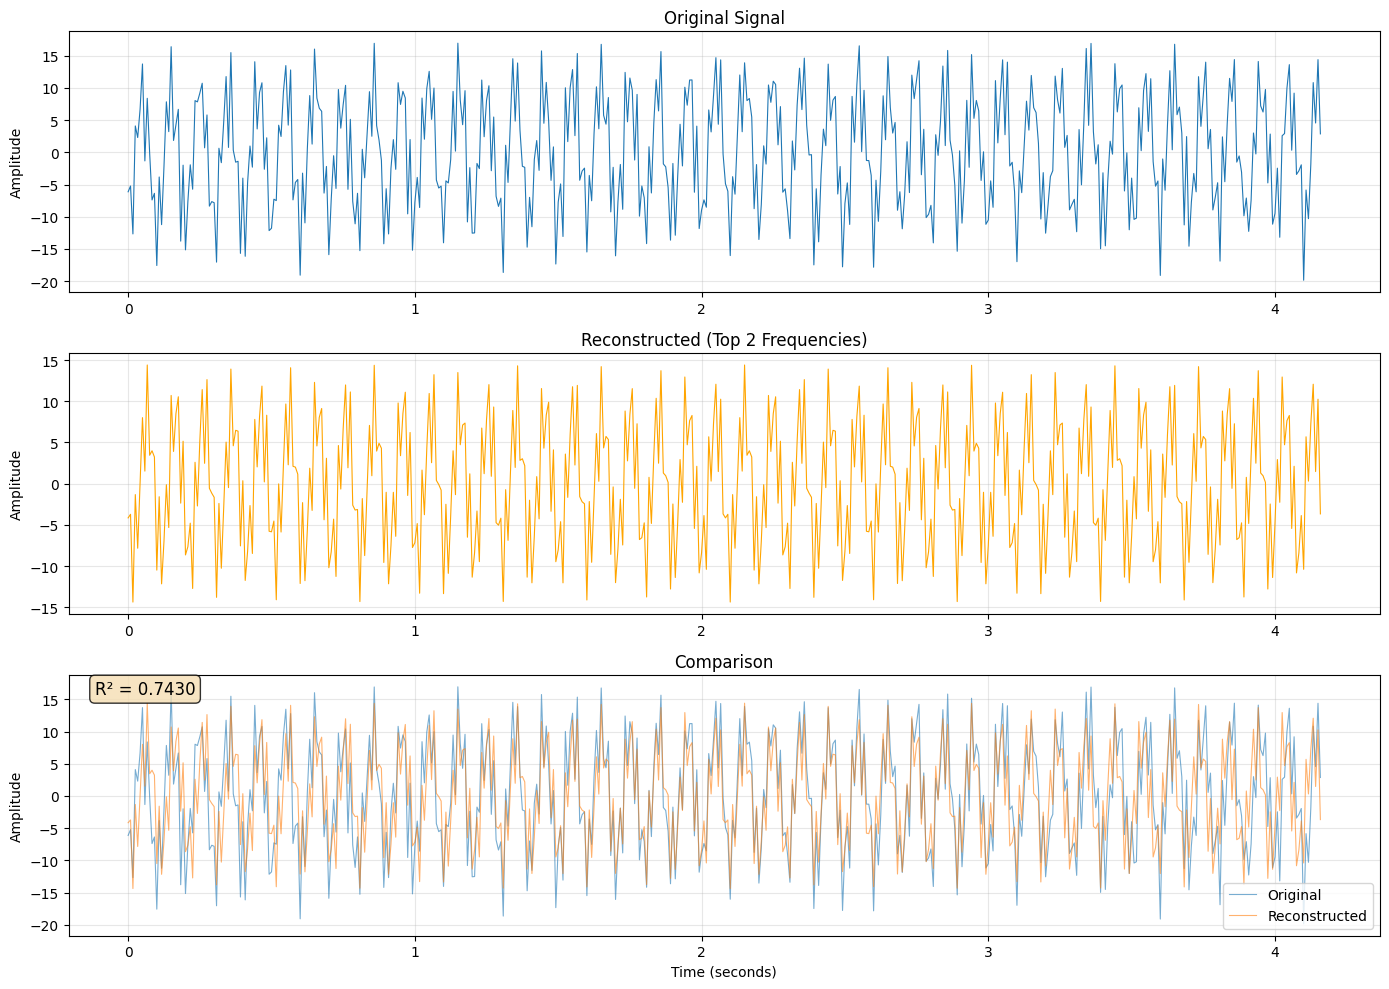

In [25]:
k = 2  # Configure: number of top frequencies to use
freq_info = extract_top_frequencies(signal, fs, k=k)

# Print frequencies
print(f"Top {k} Frequencies:")
print("-" * 50)
for i, (freq, amp) in enumerate(zip(freq_info['frequencies'], freq_info['amplitudes'])):
    print(f"{i+1}. {freq:6.2f} Hz  |  Amplitude: {amp:6.2f}")
print("-" * 50)

# Reconstruct signal
reconstructed = reconstruct_signal(freq_info, fs, len(signal))

# Calculate quality
r_squared = np.corrcoef(signal, reconstructed)[0, 1]**2
rmse = np.sqrt(np.mean((signal - reconstructed)**2))

print(f"\nReconstruction Quality:")
print(f"  R² (variance explained): {r_squared:.4f} ({r_squared*100:.1f}%)")
print(f"  RMSE: {rmse:.4f}")

# Plot
plot_comparison(t_actual, signal, reconstructed, freq_info, k)